In [1]:
import torch
import numpy as np
import torchvision
import torchvision.transforms as transforms
from torch.utils.tensorboard import SummaryWriter
from torch.optim.sgd import SGD
from torchvision import models
from torchsummary import summary
import torch.nn as nn
import torch.nn.functional as F
from torchmetrics import F1Score, Accuracy

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


## Assignment 2 in ML. Task 2
### Ostapovich Oleg
#### Section 1: Data Reading

In [3]:
epochs = 20
learning_rate = 0.001

In [4]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Resize([32,32]),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

dataset = torchvision.datasets.GTSRB(root='./data', download=True, transform=transform)

#### Section 2: Exploration and preprocessing

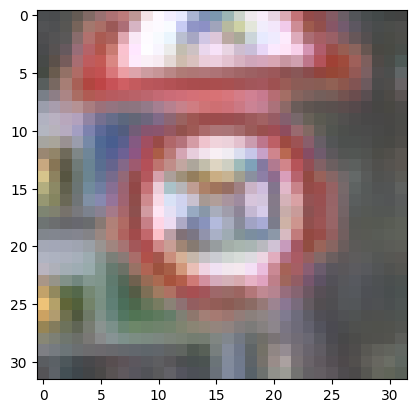

In [5]:
import matplotlib.pyplot as plt
img = dataset.__getitem__(0).__getitem__(0)
img = img / 2 + 0.5
npimg = img.numpy()
plt.imshow(np.transpose(npimg, (1, 2, 0)))
plt.show()

In [5]:
#Data splitting
train_size, val_size, test_size = int(len(dataset)*0.7), int(len(dataset)*0.1), int(len(dataset)*0.2)
train_dataset,val_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])

In [6]:
batch_size = 128
test_batch_size = 100

trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)
valloader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=test_batch_size,
                                          shuffle=True, num_workers=2)

In [7]:
input_shape = dataset.__getitem__(0).__getitem__(0).numpy().shape
print(input_shape)

(3, 32, 32)


#### Section 3.1: Machine learning or Deep learning model defining, training and hyper-parameters turning

In [34]:
class StartModel(nn.Module):
    def __init__(self):
        super(StartModel, self).__init__()
        self.network=nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1),
            nn.Conv2d(32, 32, 3, padding=1),

            nn.MaxPool2d(2, 2),

            nn.Conv2d(32, 64, 3,padding=1),
            nn.Conv2d(64, 64, 3,padding=1),

            nn.MaxPool2d(2, 2),

            nn.Conv2d(64, 128, 3,padding=1),
            nn.Conv2d(128, 128, 3,padding=1),

            nn.MaxPool2d(2, 2),

            nn.Flatten(),

            nn.Linear(2048, 512),
            nn.Linear(512, 43))

    def forward(self, x):
        return self.network(x)

startmodel = StartModel().to(device)
summary(startmodel, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             896
            Conv2d-2           [-1, 32, 32, 32]           9,248
         MaxPool2d-3           [-1, 32, 16, 16]               0
            Conv2d-4           [-1, 64, 16, 16]          18,496
            Conv2d-5           [-1, 64, 16, 16]          36,928
         MaxPool2d-6             [-1, 64, 8, 8]               0
            Conv2d-7            [-1, 128, 8, 8]          73,856
            Conv2d-8            [-1, 128, 8, 8]         147,584
         MaxPool2d-9            [-1, 128, 4, 4]               0
          Flatten-10                 [-1, 2048]               0
           Linear-11                  [-1, 512]       1,049,088
           Linear-12                   [-1, 43]          22,059
Total params: 1,358,155
Trainable params: 1,358,155
Non-trainable params: 0
---------------------------

In [35]:
class ImprovedModel(nn.Module):
    def __init__(self):
        super(ImprovedModel, self).__init__()
        self.network=nn.Sequential(
            nn.Conv2d(3,32,3,padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),

            nn.Conv2d(32,32,3,padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),

            nn.MaxPool2d(2,2),
            nn.Dropout2d(0.25),

            nn.Conv2d(32,64,3,padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.Conv2d(64,64,3,padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.MaxPool2d(2,2),
            nn.Dropout2d(0.25),

            nn.Conv2d(64,128,3,padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),

            nn.Conv2d(128,128,3,padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),

            nn.MaxPool2d(2,2),
            nn.Dropout2d(0.25),

            nn.Flatten(),

            nn.Linear(2048, 512),
            nn.BatchNorm1d(512),
            nn.Dropout(0.25),
            nn.ReLU(),

            nn.Linear(512,43))

    def forward(self, x):
        return self.network(x)

improvedmodel = ImprovedModel().to(device)
summary(improvedmodel, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             896
       BatchNorm2d-2           [-1, 32, 32, 32]              64
              ReLU-3           [-1, 32, 32, 32]               0
            Conv2d-4           [-1, 32, 32, 32]           9,248
       BatchNorm2d-5           [-1, 32, 32, 32]              64
              ReLU-6           [-1, 32, 32, 32]               0
         MaxPool2d-7           [-1, 32, 16, 16]               0
         Dropout2d-8           [-1, 32, 16, 16]               0
            Conv2d-9           [-1, 64, 16, 16]          18,496
      BatchNorm2d-10           [-1, 64, 16, 16]             128
             ReLU-11           [-1, 64, 16, 16]               0
           Conv2d-12           [-1, 64, 16, 16]          36,928
      BatchNorm2d-13           [-1, 64, 16, 16]             128
             ReLU-14           [-1, 64,

In [8]:
def train_evaluate(net, optimizer, writer):
    criterion = nn.CrossEntropyLoss()
    accuracy_func = Accuracy(num_classes=43, average='weighted').to(device)
    f1_score_func = F1Score(num_classes=43, average='weighted').to(device)
    for epoch in range(epochs):

        running_loss = 0.0
        f1 = 0
        accuracy = 0
        for data in trainloader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

            _, pred = torch.max(outputs.data, 1)
            accuracy += accuracy_func(pred, labels) * 100
            f1 += f1_score_func(pred, labels) * 100

        running_loss /= len(trainloader)
        accuracy /= len(trainloader)
        f1 /= len(trainloader)
        writer.add_scalar('Training_Loss', running_loss, epoch)
        writer.add_scalar('Training_Accuracy', accuracy, epoch)
        writer.add_scalar('Training_F1', f1, epoch)

        print('Epoch {} - train loss:{}, accuracy:{}, f1_score:{}'.format(epoch+1, running_loss, accuracy, f1))

        val_loss = 0.0
        val_accuracy = 0
        val_f1_score = 0
        with torch.no_grad():
            for data in valloader:
                inputs, labels = data
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad()
                outputs = net(inputs)
                loss = criterion(outputs, labels)
                _, pred = torch.max(outputs.data, 1)
                val_loss += loss.item()
                val_accuracy += accuracy_func(pred, labels) * 100
                val_f1_score += f1_score_func(pred, labels) * 100
            val_loss /= len(valloader)
            val_accuracy /= len(valloader)
            val_f1_score /= len(valloader)
            writer.add_scalar('Val_Loss', val_loss, epoch)
            writer.add_scalar('Val_Accuracy', val_accuracy, epoch)
            writer.add_scalar('Val_F1', val_f1_score, epoch)

        print('Epoch {} - val loss:{}, accuracy:{}, f1_score:{}'.format(epoch+1, val_loss, val_accuracy, val_f1_score))

#### Section 4.1: Model performance evaluation

In [37]:
# model without improving
optimizer = torch.optim.SGD(startmodel.parameters(), lr=learning_rate)
writer = SummaryWriter('runs/BaseModel')
train_evaluate(startmodel, optimizer, writer)

Epoch 1 - train loss:3.7582443136058443, accuracy:4.268660545349121, f1_score:0.6849289536476135
Epoch 1 - val loss:3.7552818684350875, accuracy:4.395604610443115, f1_score:0.659843921661377
Epoch 2 - train loss:3.7527905375990147, accuracy:4.5551838874816895, f1_score:0.7434865236282349
Epoch 2 - val loss:3.7500659284137545, accuracy:4.581616401672363, f1_score:0.6628457903862
Epoch 3 - train loss:3.747281740789544, accuracy:4.641286849975586, f1_score:0.7538985013961792
Epoch 3 - val loss:3.74482798576355, accuracy:4.630265712738037, f1_score:0.6736736297607422
Epoch 4 - train loss:3.7415225669129253, accuracy:4.69382381439209, f1_score:0.7490038275718689
Epoch 4 - val loss:3.7391048840114047, accuracy:4.544414043426514, f1_score:0.6756264567375183
Epoch 5 - train loss:3.735279465374881, accuracy:4.657340049743652, f1_score:0.7271203398704529
Epoch 5 - val loss:3.7328363827296664, accuracy:4.564445972442627, f1_score:0.6915250420570374
Epoch 6 - train loss:3.72812682798464, accuracy:

In [38]:
optimizer = torch.optim.SGD(improvedmodel.parameters(), lr=learning_rate)
writer2 = SummaryWriter('runs/ImprovedModel')
train_evaluate(improvedmodel, optimizer, writer2)

Epoch 1 - train loss:3.714235869172501, accuracy:5.285355567932129, f1_score:4.455452919006348
Epoch 1 - val loss:3.631051880972726, accuracy:7.366071701049805, f1_score:5.5320143699646
Epoch 2 - train loss:3.5578197044868993, accuracy:8.185126304626465, f1_score:5.916228771209717
Epoch 2 - val loss:3.507082473664057, accuracy:9.32348918914795, f1_score:6.940835952758789
Epoch 3 - train loss:3.45314037309934, accuracy:9.927128791809082, f1_score:7.262463569641113
Epoch 3 - val loss:3.4246347972324918, accuracy:10.75148868560791, f1_score:7.797257900238037
Epoch 4 - train loss:3.3760843325967658, accuracy:12.060242652893066, f1_score:9.08124828338623
Epoch 4 - val loss:3.351353656677973, accuracy:12.276785850524902, f1_score:9.03854751586914
Epoch 5 - train loss:3.3037756518141865, accuracy:13.666037559509277, f1_score:10.38022232055664
Epoch 5 - val loss:3.2881591660635814, accuracy:13.570283889770508, f1_score:10.465517044067383
Epoch 6 - train loss:3.236494681606554, accuracy:15.5671

### Task2.2

#### Section 3.2: Machine learning or Deep learning model defining, training and hyper-parameters turning

In [9]:
class Identity(torch.nn.Module):
    def __init__(self):
        super(Identity, self).__init__()

    def forward(self, x):
        return x

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [13]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.net = models.resnet18()
        self.net.trainable = False # Freeze the layers of the pretrained model
        self.net.fc = nn.Linear(512, 43)

    def forward(self, x):
        return self.net(x)

shuff = Net().to(device)
summary(shuff, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 16, 16]           9,408
       BatchNorm2d-2           [-1, 64, 16, 16]             128
              ReLU-3           [-1, 64, 16, 16]               0
         MaxPool2d-4             [-1, 64, 8, 8]               0
            Conv2d-5             [-1, 64, 8, 8]          36,864
       BatchNorm2d-6             [-1, 64, 8, 8]             128
              ReLU-7             [-1, 64, 8, 8]               0
            Conv2d-8             [-1, 64, 8, 8]          36,864
       BatchNorm2d-9             [-1, 64, 8, 8]             128
             ReLU-10             [-1, 64, 8, 8]               0
       BasicBlock-11             [-1, 64, 8, 8]               0
           Conv2d-12             [-1, 64, 8, 8]          36,864
      BatchNorm2d-13             [-1, 64, 8, 8]             128
             ReLU-14             [-1, 6

In [101]:
class NetReduced(nn.Module):
    def __init__(self):
        super(NetReduced, self).__init__()
        self.net = models.shufflenet_v2_x1_5()
        self.net.trainable = False # Freeze the layers of the pretrained model
        self.net.conv5 = Identity()
        self.net.fc = nn.Linear(704, 43)

    def forward(self, x):
        return self.net(x)

shuffreduced = NetReduced().to(device)
summary(shuffreduced, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 24, 16, 16]             648
       BatchNorm2d-2           [-1, 24, 16, 16]              48
              ReLU-3           [-1, 24, 16, 16]               0
         MaxPool2d-4             [-1, 24, 8, 8]               0
            Conv2d-5             [-1, 24, 4, 4]             216
       BatchNorm2d-6             [-1, 24, 4, 4]              48
            Conv2d-7             [-1, 88, 4, 4]           2,112
       BatchNorm2d-8             [-1, 88, 4, 4]             176
              ReLU-9             [-1, 88, 4, 4]               0
           Conv2d-10             [-1, 88, 8, 8]           2,112
      BatchNorm2d-11             [-1, 88, 8, 8]             176
             ReLU-12             [-1, 88, 8, 8]               0
           Conv2d-13             [-1, 88, 4, 4]             792
      BatchNorm2d-14             [-1, 8

#### Section 4.2: Model performance evaluation

In [14]:
optimizer = torch.optim.SGD(shuff.parameters(),lr=learning_rate)
writer3 = SummaryWriter('runs/TLmodel')
train_evaluate(shuff, optimizer, writer3)

Epoch 1 - train loss:3.530795855064915, accuracy:10.454448699951172, f1_score:8.674538612365723
Epoch 1 - val loss:3.1678708507901145, accuracy:19.79452896118164, f1_score:16.97509765625
Epoch 2 - train loss:2.930984519932368, accuracy:25.883405685424805, f1_score:22.107994079589844
Epoch 2 - val loss:2.7444336187271845, accuracy:31.169872283935547, f1_score:27.11604881286621
Epoch 3 - train loss:2.55049563434026, accuracy:35.7779426574707, f1_score:31.47150230407715
Epoch 3 - val loss:2.430770306360154, accuracy:39.631980895996094, f1_score:35.63232421875
Epoch 4 - train loss:2.2400659935115135, accuracy:45.12424087524414, f1_score:40.99833679199219
Epoch 4 - val loss:2.153460729689825, accuracy:47.28136444091797, f1_score:43.31380844116211
Epoch 5 - train loss:1.9634428391717884, accuracy:53.386226654052734, f1_score:49.334327697753906
Epoch 5 - val loss:1.9338504870732625, accuracy:51.917354583740234, f1_score:48.22197723388672
Epoch 6 - train loss:1.7352579358505875, accuracy:58.75

In [104]:
optimizer = torch.optim.SGD(shuffreduced.parameters(),lr=learning_rate)
writer4 = SummaryWriter('runs/TLmodelReduced')
train_evaluate(shuffreduced, optimizer, writer4)

Epoch 1 - train loss:3.7283972648725117, accuracy:4.090130805969238, f1_score:3.603311061859131
Epoch 1 - val loss:3.658048255102975, accuracy:5.40865421295166, f1_score:4.173295021057129
Epoch 2 - train loss:3.5928740844334643, accuracy:6.614356517791748, f1_score:5.0245137214660645
Epoch 2 - val loss:3.566355376016526, accuracy:6.616300582885742, f1_score:5.01871919631958
Epoch 3 - train loss:3.5160380667203093, accuracy:7.818824291229248, f1_score:5.703953742980957
Epoch 3 - val loss:3.517203137988136, accuracy:7.26591157913208, f1_score:5.1585612297058105
Epoch 4 - train loss:3.473716384743991, accuracy:8.59375, f1_score:6.263426303863525
Epoch 4 - val loss:3.4733046690622964, accuracy:8.688186645507812, f1_score:6.381995677947998
Epoch 5 - train loss:3.428969357111683, accuracy:9.904265403747559, f1_score:7.166472911834717
Epoch 5 - val loss:3.443641878309704, accuracy:9.858631134033203, f1_score:6.768109321594238
Epoch 6 - train loss:3.385286269122607, accuracy:11.438064575195312

#### Section 5: Conclusion and possible improvements